# Preprocessing Wellington Data

**This dataset includes raw data required to calculate carbon emissions, our focus is on studying the decrease in carbon emissions for buses primarily designated for reducing carbon emissions, rather than buses primarily utilized for passenger transportation.**

**While weekend buses tend to be predominantly employed for passenger transportation, it's important to note that weekday buses also serve as a means of passenger transport. However, during weekdays, buses take on an additional role: they are strategically utilized for carbon reduction efforts, particularly during peak hours like 7am-9am and 4pm-6pm.**

### NetBI

The following dimensions were used to generate the datasets

X:
- Actual Running Time
- Actual In-Service KM
- Passenger Km
- Scheduled In-Service Km
- Cancelled Trips
- Sched Running Time per Trip

Y:
- Data
- Route
- Route Variant
- Direction
- Trip Number
- Actual Vehicle Type
- Vehicle Number
- Vehicle Emissions Standard
- Start Minute(Sched)
- Day

### Goals

- Split running time into, hourly run time intervals
- Calculate Average speed of a bus (distance/time) <input type="checkbox" checked> 
- Calculate Average Occupancy (passenger Km/ actual km <input type="checkbox" checked> 
- Calculate Carbon for routes <input type="checkbox" checked>
- Calculate the per person carbon emissions reduction
- tydy up emissions calculations description based on latest info from Josh

### Further Goals

- Create Heat Map
- Learn how to upload data to mongoDB
- Integrate heat map into Bean

 - please note, that this analysis does not account for canclelled buses, only those that ran. We have no time to fit this part of analysis in.
 

### Where I left off on 6 September (Oxana):

- Trying to create an itneractive plot
- thinking what should be on X and Y axis of the plot, which should be the filters?
- Also at this stage could not figure out how to explort the interactive plot outside of python

### Where I left off on 13 September (Oxana):

- merged trips data with fleetmaster to find out tareWeight of each bus. About 30% of info missing, checking with Hamish on this.
- created function that calculates emissions
- added the column to the data that calculates emissions
- need to add another calc for emissions for ELECTRIC bus, perhaps its just zero, did not have time to find out
- after the above is ironed out, need to aggregate the data per route per weekday and per hour of the day
 - next plot it


### Loading Data

In [1]:
#I needed to install dash first
# pip install dash


import pandas as pd
import numpy as np
import plotly.express as px
from ipywidgets import interact, widgets
import plotly.graph_objs as go

# # Load and process DataFrames
# jan1_3 = pd.read_csv("Wellington Raw Daily Data/Jan 1-3 2022.csv")
# jan4_6 = pd.read_csv("Wellington Raw Daily Data/Jan 4-6 2022.csv")
# jan7_9 = pd.read_csv("Wellington Raw Daily Data/Jan 7-9 2022.csv")
# jan10_11 = pd.read_csv("Wellington Raw Daily Data/Jan 10-11 2022.csv")
# jan12_13 = pd.read_csv("Wellington Raw Daily Data/Jan 12-13 2022.csv")
# jan14_15 = pd.read_csv("Wellington Raw Daily Data/Jan 14-15 2022.csv")
# jan16_17 = pd.read_csv("Wellington Raw Daily Data/Jan 16-17 2022.csv")
# jan18_19 = pd.read_csv("Wellington Raw Daily Data/Jan 18-19 2022.csv")
# jan20_21 = pd.read_csv("Wellington Raw Daily Data/Jan 20-21 2022.csv")
# jan22_23 = pd.read_csv("Wellington Raw Daily Data/Jan 22-23 2022.csv")
# jan24_25 = pd.read_csv("Wellington Raw Daily Data/Jan 24-25 2022.csv")
# jan26_27 = pd.read_csv("Wellington Raw Daily Data/Jan 26-27 2022.csv")
# jan28_29 = pd.read_csv("Wellington Raw Daily Data/Jan 28-29 2022.csv")
# jan30_31 = pd.read_csv("Wellington Raw Daily Data/Jan 30-31 2022.csv")

# # List of DataFrames
# dataframes = [
#     jan1_3, jan4_6, jan7_9, jan10_11, jan12_13,
#     jan14_15, jan16_17, jan18_19, jan20_21, jan22_23,
#     jan24_25, jan26_27, jan28_29, jan30_31
# ]

# # The bottom row of each data frame must be removed due to it being a total column.
# def drop_last_row(df):
#     return df.drop(df.tail(1).index)

# dataframes = list(map(drop_last_row, dataframes))

# # Stacking DataFrames
# combined_df = pd.concat(dataframes, ignore_index=True)

# # writing and storing processed dataframes as csv
# combined_df.to_csv("Wellington Raw Monthly Data/January 2022.csv")

# print(combined_df)


In [2]:
#read in sample data from Hamish. This dataframe contains all trips for FY2022/2023

wlgt2022_trips = pd.read_csv('Wellington Raw Data/Trips_2022-01-01_to_2023-06-30.csv')


In [3]:
#come back to this, trips with negative values seem to be train trips. We do not want train trips in this data frame.
sum(wlgt2022_trips['Passenger km']<0)

103

**Bus Speed**

The calculation of bus speed is straightforward and involves the formula where velocity equals the ratio of distance to time ( $ v = \frac{d}{t} $ ).

Since Actual Running Time is in seconds, we divide the time by 3600 to get speed in km her hour.

In [4]:
#Calculate Average speed of a bus (distance/time) with a condition to avoid division by zero
wlgt2022_trips['Speed'] = np.where(wlgt2022_trips['Actual Running Time'] != 0,
                                    wlgt2022_trips['Actual In-Service KM'] / (wlgt2022_trips['Actual Running Time'] / 3600),
                                    0)  # Set Speed to 0 when Running Time is 0

**Average Occupancy**

 Mean occupancy (per kilometre driven) equals the ratio Passenger km to Actual In-Service KM
 
 Where Passenger km is a unit of measurement representing the transport of 1 passenger over 1 km
 and Actual In-Service KM is the lengh of a trip


In [5]:
wlgt2022_trips['Average Occupancy'] = np.where(wlgt2022_trips['Actual In-Service KM'] != 0,
                                               wlgt2022_trips['Passenger km']/wlgt2022_trips['Actual In-Service KM'],
                                               0) # Set Occupancy to 0 when Distance travelled is 0

In [6]:
wlgt2022_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1312948 entries, 0 to 1312947
Data columns (total 19 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Date                         1312948 non-null  object 
 1   Route                        1312948 non-null  object 
 2   Route Variant                1312948 non-null  object 
 3   Direction                    1312948 non-null  object 
 4   Trip Number                  1312948 non-null  int64  
 5   Vehicle Number               1312948 non-null  object 
 6   Actual Vehicle Type          1312948 non-null  object 
 7   Vehicle Emissions Standard   1312948 non-null  object 
 8   Start Minute (Sched)         1312948 non-null  object 
 9   Actual Running Time          1312948 non-null  int64  
 10  Sched Running Time per Trip  1312948 non-null  int64  
 11  Actual In-Service KM         1312948 non-null  float64
 12  Scheduled In-Service km      1312948 non-n

In [17]:
# look into data that we have on Engine Type:
wlgt2022_trips['Vehicle Emissions Standard'].value_counts()
    

EURO6       551159
ELECTRIC    278966
Unknown     272776
EURO5       115678
EURO3        60146
EURO4        34223
Name: Vehicle Emissions Standard, dtype: int64

**Tare Weight**

In [8]:
# Now look up tareWeight of each bus
wlgt2022_fleetmaster = pd.read_csv('Wellington Raw Data/fleet_master.csv')
# Convert the 'Date Modified' column to datetime
wlgt2022_fleetmaster['Date Modified'] = pd.to_datetime(wlgt2022_fleetmaster['Date Modified'], format='%d/%m/%Y')

# filter fleetmaster to leave latest 'Date Modified' data only 
wlgt2022_fleetmaster = wlgt2022_fleetmaster.loc[wlgt2022_fleetmaster.groupby('Vehicle Number')['Date Modified'].idxmax()]

In [9]:
wlgt2022_fleetmaster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622 entries, 7988 to 8606
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Date Modified                            622 non-null    datetime64[ns]
 1   Vehicle Number                           622 non-null    object        
 2   Operator                                 622 non-null    object        
 3   Operator Short Code                      622 non-null    object        
 4   Operator Prefix                          622 non-null    object        
 5   Unit Number                              536 non-null    object        
 6   Mode                                     622 non-null    object        
 7   Date of First Registration               573 non-null    object        
 8   Date of Manufacture                      563 non-null    object        
 9   Bike Rack Capable                      

In [10]:
# add tare Weight info to wlgt2022_trips by merging wlgt2022_trips with wlgt2022_fleetmaster
wlgt2022_trips_merged = wlgt2022_trips.merge(wlgt2022_fleetmaster[['Vehicle Number', 'TARE Weight (KG)']], on='Vehicle Number', how='left')


# Calculate Emissions

In [11]:
#this cell is entering all the constants needed for calcs

LUBE = 0.265170857776354
PASSENGERWEIGHT = 80         #average passenger weight
DIESELDENSITY = 835          # grams per litre
emission_equations = [
    {
        "_id": "EURO6",
        "a": -0.00000490907972998,
        "b": -0.0138698794326,
        "g": 2.65774563711,
        "d": 3.2553615439,
        "e": -0.000051285329923,
        "z": 0.00498758025146,
        "h": 0.125550793946
    },
    {
        "_id": "EURO5",
        "a": -0.0000367698590941,
        "b": -0.0134678044879,
        "g": 3.05911007786,
        "d": 3.55505145507,
        "e": -0.0000618780508159,
        "z": 0.00594233596222,
        "h": 0.142419853084
    },
    {
        "_id": "EURO4",
        "a": 0.00251040331347,
        "b": -0.0863970747847,
        "g": 1.10983487462,
        "d": 14.7776496863,
        "e": 0.000327986189114,
        "z": -0.0130053588546,
        "h": 0.218081753103
    },
    {
        "_id": "EURO3",
        "a": 0.00000421475875959,
        "b": 0.0207160939587,
        "g": 1.73463013954,
        "d": 7.0692144528,
        "e": -0.0000197902932034,
        "z": 0.0062379661034,
        "h": 0.0627620452536
    },
    {
        "_id": "EURO2",
        "a": 0.00000840769603463,
        "b": 0.0200800121334,
        "g": 1.65858316407,
        "d": 6.77362500033,
        "e": -0.0000201599863213,
        "z": 0.00634399262596,
        "h": 0.0638032158354
    },
    {
        "_id": "EURO1",
        "a": -0.00000137497057894,
        "b": 0.0209960875758,
        "g": 1.88066742017,
        "d": 7.94657629399,
        "e": -0.0000215438923697,
        "z": 0.00682789815225,
        "h": 0.00682789815225
    },
    {
        "_id": "PREEURO",
        "a": -0.00000656462584868,
        "b": 0.0178339567319,
        "g": 1.79325857679,
        "d": 7.7207331411,
        "e": -0.0000181010843656,
        "z": 0.00549860697303,
        "h": 0.045663294005
    }
]

#The following are 
CH4 = {
    "PREEURO": 0.175,
    "EURO1": 0.175,
    "EURO2": 0.11375,
    "EURO3": 0.10325,
    "EURO4": 0.00525,
    "EURO5": 0.00525,
    "EURO6": 0.00525,
    "CO2FACTOR": 25
}

# N2O.CO2FACTOR converts the N20 realsed to its C02 equivilent. 
# This is to say, how much greenhouse effect does this have over its time in the apnosphere. 
# How much CO2 is needed to have the same effect as this much N20. 
# The numbers we have in the code are used by a previous group however I did my own research and found slightly different numbers. I really want to put them in but I don't know where their numbers come from and I can't find any through research.

# CalcN20 is the greenhouse effectivness of N20 compared to CO

# Just looking at this it looks wrong.
# I would think taht the numbers would decrease as the euros get smaller, not increase. 
# I think that it is reasonable to say that the numbers are the wrong way around. 
# However for consistency with BEAn I am keeping it as is.
N2O = {
    "PREEURO"  : 0.030,            
    "EURO1"     : 0.012,
    "EURO2"     : 0.012,
    "EURO3"     : 0.006,
    "EURO4"     : 0.0128,
    "EURO5"     : 0.0332,
    "EURO6"     : 0.0415,
    "CO2FACTOR": 298
}

In [12]:
# this cell defines a function for emissions calculation

# calculate the emissions in grams per KM


# You can access the dictionary for each engine using the engine name as the key.

def calcCO2equiv(row):
    
    
    tareWeight = row['TARE Weight (KG)'] 
    aveOccupancy = row['Average Occupancy'] 
    distance = row['Actual In-Service KM']
    speed = row['Speed']
    euro = row['Vehicle Emissions Standard']
    
    if speed == 0:
        CO2emissions = 0 
    elif euro == 'ELECTRIC':
        CO2emissions = "another calc" #to be worked out later
    elif euro =='Unknown':
        CO2emissions = "cannot establish"
    else:
        for item in emission_equations: #looking up values for calculating fuel consumption depending on engine type
            if item["_id"] == euro:
                a = item["a"]
                b = item["b"]
                g = item["g"]
                d = item["d"]
                e = item["e"]
                z = item["z"]
                h = item["h"]

                
        # **Step 1.** Calculate weight factors:

        loadedWeight = tareWeight + aveOccupancy * PASSENGERWEIGHT
        tareFactor =   (0.00004711 * tareWeight) + 0.446
        loadedFactor = (0.00004711 * loadedWeight) + 0.446
        # **Step 2** Calculate fuelConsumed
        fuelConsumedStandard = 100/(45.79 * DIESELDENSITY/1000)*(a * speed**2+b * speed+g+d/speed)/(e*speed**2 + z*speed + h) #L/lm
        #note: ** is power operator (^)
        fuelConsumedAdjusted = fuelConsumedStandard * (loadedFactor * distance + tareFactor * distance*0.15) 
        # note: distance*0.15 is repositioning distance 
        # The 0.15 is accounting for an approximation 15% of the journey the bus travels to either get back to the bus depo or start the next route
        # **Step 3** Calculate fuelEmissions
        fuelEmissions = fuelConsumedAdjusted * 69.31 * DIESELDENSITY * 45.79/100000 #69.31 is CO2 emission factor (tCO2/TJ)
        oilEmissions = distance * LUBE
        CO2emissions = fuelEmissions + oilEmissions
        
        #**Step 4.** Add emissions from all pollutants: 
        CH4Emissions = distance * CH4[euro] * CH4['CO2FACTOR']
        N2OEmissions = distance * N2O[euro] * N2O['CO2FACTOR']
        
               
    return CO2emissions
    
    

In [15]:
wlgt2022_trips_merged['CO2emissions'] = wlgt2022_trips_merged.apply(calcCO2equiv, axis = 1)

In [37]:
wlgt2022_trips_merged['CO2emissions'].describe()

count    9.581860e+05
mean     9.392921e+03
std      6.033191e+04
min     -1.187690e+07
25%      2.738973e+03
50%      8.429086e+03
75%      1.352473e+04
max      3.673509e+07
Name: CO2emissions, dtype: float64

In [19]:
wlgt2022_trips_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1312948 entries, 0 to 1312947
Data columns (total 21 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Date                         1312948 non-null  object 
 1   Route                        1312948 non-null  object 
 2   Route Variant                1312948 non-null  object 
 3   Direction                    1312948 non-null  object 
 4   Trip Number                  1312948 non-null  int64  
 5   Vehicle Number               1312948 non-null  object 
 6   Actual Vehicle Type          1312948 non-null  object 
 7   Vehicle Emissions Standard   1312948 non-null  object 
 8   Start Minute (Sched)         1312948 non-null  object 
 9   Actual Running Time          1312948 non-null  int64  
 10  Sched Running Time per Trip  1312948 non-null  int64  
 11  Actual In-Service KM         1312948 non-null  float64
 12  Scheduled In-Service km      1312948 non-n

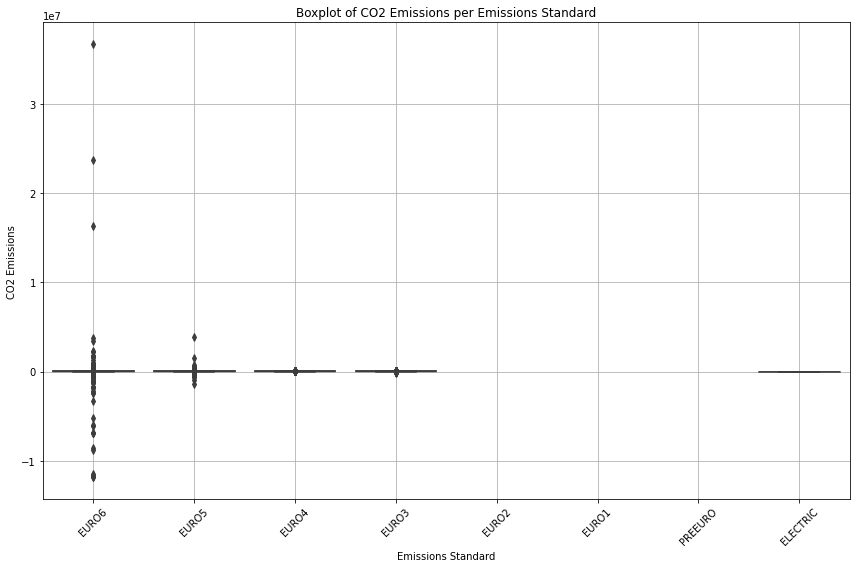

In [36]:
# just checking how this looks:
import seaborn as sns
import matplotlib.pyplot as plt

forPlot = wlgt2022_trips_merged.copy()
forPlot['CO2emissions'] = pd.to_numeric(forPlot['CO2emissions'], errors='coerce')

plt.figure(figsize=(12, 8))
sns.boxplot(x='Vehicle Emissions Standard', y='CO2emissions', data=forPlot, order=emissions_standard_mapping.keys())
plt.xticks(rotation=45)
plt.xlabel('Emissions Standard')
plt.ylabel('CO2 Emissions')
plt.title('Boxplot of CO2 Emissions per Emissions Standard')
plt.grid(True)
plt.tight_layout()
plt.show()

**aggregating the data for plotting**
come back to this

In [24]:
wlgt2022_trips_merged['CO2emissions'] = pd.to_numeric(wlgt2022_trips_merged['CO2emissions'], errors='coerce')

# Group by "Route," "Day of Week," and "Start Minute" and aggregate using desired functions

aggregated_df = wlgt2022_trips_merged.groupby(["Route", "Day of Week", "Start Minute (Sched)"]).agg({
    "Trip Number": "count",  # Count of trips
    "Actual Running Time": "sum",  # Sum of running times
    "Actual In-Service KM": "sum",  # Sum of scheduled in-service km
    "Passenger km": "sum",  # Sum of passenger km
    'Speed': "mean",
    'Average Occupancy': 'mean',
    "CO2emissions": "mean"  # Calculate mean of CO2emissions
}).reset_index()

# rename the columns for clarity
aggregated_df.columns = ["Route", "Day of Week", "Start Minute", "Trip Count", "Total Running Time",
                         "Total Actual In-Service km", "Total Passenger km", "Mean Speed", "Mean Occupancy", 
                         "Mean CO2 Emissions"]

In [31]:
#investigate why some emissions are less than zero

sum(aggregated_df['Mean CO2 Emissions']<0)

67

**Average car occupancy**

We use the assumption that on average 1.3 passengers travel in each car. To calculate how many Car km it would take to transport the same number of passengers we divide Passenger km by 1.3

**CO_2 emissions**

CO_2 are taken to be 0.265 kg per Car km. 
To calculate how much CO_2 would be emitted if the bus passengers travelled by a private car we use the following calculation:
$$ CO_2 emissions = \frac{0.265\times Passenger km}{1.3} $$

**Valuation of CO_2 emissions**

The whole-of-government agreed shadow price of carbon ($ per tonne of CO2 equivalent) emissions, in Table 1, is to be used for calculating the economic impact of carbon for transport activities.  This means applying the **central** price path as the default analysis in the economic evaluation of transport proposals and accompanying this with sensitivity analysis based on the low and high price paths. Quoted from here: https://www.nzta.govt.nz/assets/resources/monetised-benefits-and-costs-manual/Monetised-benefits-and-costs-manual.pdf

Table 1: Shadow Price of Carbon (NZ$2022 per tonne of CO2 equivalent)



| Year  | 2023  | 2024  | 2025  | 2026  | 2027  | 2028  | 2029  | 2030  | 2031  | 2032  | 2033  | 2034  |
|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| Low   | \$59  | \$65  | \$72  | \$78  | \$85  | \$91  | \$98  | \$104 | \$108 | \$112 | \$116 | \$120 |
| Middle| \$87  | \$97  | \$107 | \$116 | \$126 | \$136 | \$146 | \$155 | \$161 | \$167 | \$174 | \$180 |
| High  | \$171 | \$182 | \$193 | \$203 | \$214 | \$219 | \$224 | \$230 | \$235 | \$241 | \$247 | \$253 |


Therefore the calculation for shadow cost of CO_2 if the same trip was taken by private cars looks as follows:
(dividing by 1000 as price is per tonne)

$$ CO_2 shadow \ cost = \frac{0.265\times Passenger km\times \$\ Middle \ price for 2023}{1.3\times1000} $$

Please note that part of our data is from 2022, so technically we should be using 2022 price for that part:
Should your analysis require shadow prices for years prior to 2023, email MBCM@nzta.govt.nz.  

In [32]:
#you can update shadow price here if you want to use it for a different year
shadow_price2023 = 87

wlgt2022_trips['CO2cost'] = wlgt2022_trips['Passenger km']*0.265*shadow_price2023/(1.3*1000)

In [ ]:
# First attempt to create interactive plot

In [64]:
import pandas as pd
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

app = dash.Dash(__name__)

# Layout of the web app
app.layout = html.Div([
    html.Label('Select Day of Week:'),
    dcc.Dropdown(
        id='day-dropdown',
        options=[{'label': day, 'value': day} for day in wlgt2022_trips['Day of Week'].unique()],
        value=wlgt2022_trips['Day of Week'].unique()[0]
    ),
    
    html.Label('Select Start Time (Sched):'),
    dcc.Dropdown(
        id='time-dropdown',
        options=[{'label': time, 'value': time} for time in wlgt2022_trips['Start Minute (Sched)'].unique()],
        value=wlgt2022_trips['Start Minute (Sched)'].unique()[0]
    ),
    
    dcc.Graph(id='co2-cost-plot')
])

# Callback function to update the plot based on dropdown selections
@app.callback(
    Output('co2-cost-plot', 'figure'),
    [Input('day-dropdown', 'value'), Input('time-dropdown', 'value')]
)
def update_plot(selected_day, selected_time):
    filtered_df = wlgt2022_trips[(wlgt2022_trips['Day of Week'] == selected_day) & (wlgt2022_trips['Start Minute (Sched)'] == selected_time)]
    
    fig = px.scatter(filtered_df, x='Date', y='CO2cost', title=f'CO2 Cost for {selected_day} - {selected_time}')
    
    fig.update_xaxes(title_text='Date')
    fig.update_yaxes(title_text='CO2 Cost')
    
    return fig

if __name__ == '__main__':
    app.run_server(debug=False)


In [90]:
# 2nd attempt, trying to explore what dimentions the plot should have
# check package tkinter, gui, flask app
app = dash.Dash(__name__)

# Layout of the web app
app.layout = html.Div([
    html.Label('Select Days of the Week:'),
    dcc.Checklist(
        id='day-checkboxes',
        options=[{'label': day, 'value': day} for day in wlgt2022_trips['Day of Week'].unique()],
        value=wlgt2022_trips['Day of Week'].unique()  # All days initially selected
    ),
    
    html.Label('Select Start Time (Sched):'),
    dcc.Dropdown(
        id='time-dropdown',
        options=[{'label': time, 'value': time} for time in wlgt2022_trips['Start Minute (Sched)'].unique()],
        value=wlgt2022_trips['Start Minute (Sched)'].unique()[0]
    ),
    
    html.Div(id='total-co2-cost'),  # Display the total CO2 cost
    dcc.Graph(id='co2-cost-plot')
])

# Callback function to update the plot based on checkbox selections and time dropdown
@app.callback(
    [Output('co2-cost-plot', 'figure'), Output('total-co2-cost', 'children')],
    [Input('day-checkboxes', 'value'), Input('time-dropdown', 'value')]
)
def update_plot(selected_days, selected_time):
    filtered_df = wlgt2022_trips[(wlgt2022_trips['Day of Week'].isin(selected_days)) & (wlgt2022_trips['Start Minute (Sched)'] == selected_time)]
    
    total_co2_cost = filtered_df['CO2cost'].sum()  # Calculate the total CO2 cost
    
    fig = px.scatter(filtered_df, x='Day of Week', y='CO2cost', title=f'CO2 Cost for Days of the Week - {selected_time}')
    
    fig.update_xaxes(title_text='Day of Week')
    fig.update_yaxes(title_text='CO2 Cost')
    
    return fig, f'Total CO2 Cost: {total_co2_cost:.2f}'

if __name__ == '__main__':
    app.run_server(debug=False)